In [304]:
import cvxpy as cp
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import lognorm
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')
from cvxpy.atoms.norm_inf import norm_inf

In [305]:
def prob_news(K,P):
    """Create the problem in cvxpy
    Parameters
    ----------
    K: int
        Number of data samples (clusters)
    -------
    The instance and parameters of the cvxpy problem
    """

    wk = cp.Parameter(K)
    eps = cp.Parameter()
    d_train = cp.Parameter(K)
    x = cp.Variable(1)
    s = cp.Variable(K)
    lam = cp.Variable()
    gamma_0 = cp.Variable((K,2))
    gamma_1 = cp.Variable((K,2))
    gamma_2 = cp.Variable((K,2))
    gamma_3 = cp.Variable((K,2))
    
    d = np.array([[0], [100]])
    C = np.array([[-1],[1]])

    objective = cp.Minimize(eps*lam + s@wk)
    constraints = []
    # formulate constraints

    for k in range(K):
             
        constraints += [gamma_0[k:k+1,:]@(d - C*d_train[k]) <= s[k]]
        constraints += [norm_inf(gamma_0[k,:]@C) <= lam]
        constraints += [gamma_0 >= 0]

        constraints += [10*x -10*d_train[k] + gamma_1[k:k+1,:]@(d - C*d_train[k]) <= s[k]]
        constraints += [norm_inf(gamma_1[k,:]@C + 10) <= lam]
        constraints += [gamma_1 >= 0]

        constraints += [-20*x + 20*d_train[k] + gamma_2[k:k+1,:]@(d - C*d_train[k]) <= s[k]]
        constraints += [norm_inf(gamma_2[k,:]@C - 20) <= lam]
        constraints += [gamma_2 >= 0]

        constraints += [(10-20)*x + (20-10)*d_train[k] + gamma_3[k:k+1,:]@(d - C*d_train[k]) <= s[k]]
        constraints += [norm_inf(gamma_3[k,:]@C + (10-20)) <= lam]  
        constraints += [gamma_3 >= 0]

    constraints += [lam >= 0, x >=0, x<= P]
    
    problem = cp.Problem(objective, constraints)

    return problem, x, s, gamma_0, gamma_1, gamma_2, gamma_3, lam, d_train, wk, eps

In [306]:
def gen_demand(N,seed, mu, sig, P):
    """ Generates log-normal demand, clipped to be within polyhedral"""
    np.random.seed(seed)
    # Create the log-normal distribution
    #s = sig  # Shape parameter for lognorm
    #scale = np.exp(mu)  # Scale parameter for lognorm
    #lognormal_dist = lognorm(s=s, scale=scale)
    a = 1 + (sig / mu) ** 2
    s = np.sqrt(np.log(a))
    scale = mu / np.sqrt(a)

    # Generate log-normal distribution
    #samples = lognorm.rvs(s=s, scale=scale, size=10000)

    # Clip the samples between 0 and 100
    #samples = np.clip(samples, 0, 100)
    lognormal_dist = lognorm(s=s, scale=scale)

    # Generate random samples
    samples = lognormal_dist.rvs(size=N)

    true_dist = lognormal_dist.rvs(size=10000)

    # Plot the probability density function (pdf)
    x = np.linspace(0, P, 100)
    plt.plot(x, lognormal_dist.pdf(x), label='Log-Normal PDF')
    plt.plot(x, lognormal_dist.cdf(x), label='Log-Normal CDF')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title('Log-Normal Distribution (0 to P)')
    plt.legend()
    plt.show()
    return samples, true_dist, s, scale

In [307]:
def position_points(K, P):
    # Generate K equally spaced initial centroids
    centroids = np.linspace(0+2, P-2, K).reshape(-1, 1)

    # Initialize K-means with the centroids
    kmeans = KMeans(n_clusters=K, init=centroids, n_init=1, max_iter=200)

    # Fit K-means to the data (which is just the centroids)
    kmeans.fit(centroids)

    # Get the final centroids (positions of the points)
    final_centroids = kmeans.cluster_centers_.flatten()
    
    # Calculate the minimum distance between adjacent centroids
    distances = np.diff(final_centroids)
    min_distance = np.min(distances)

    # Calculate mu (half of the minimum distance)
    rad = min_distance / 2.0

    plt.scatter(final_centroids,np.ones(K,))

    return rad, final_centroids

In [308]:
def get_initial_weigths(d_train,atoms):
    # Compute distances between each data point and the centroids
    #distances_to_centroids = pairwise_distances(d_train.reshape(1,-1), atoms, metric='euclidean')
    d_train = np.reshape(d_train, (-1, 1))
    atoms = np.reshape(atoms, (-1, 1))
    
    distances = cdist(d_train, atoms, metric='euclidean')
    
    # Assign each data point to the closest centroid
    cluster_assignment = np.argmin(distances, axis=1)
    cluster_assignment = cluster_assignment.tolist()

    #cluster_counts = np.bincount(cluster_assignment)
    counter = np.empty(atoms.shape[0])
    for k in range(atoms.shape[0]):
        counter[k] = cluster_assignment.count(k)

    total_data_points = len(d_train)
    weights = counter / total_data_points
    
    return weights, counter

In [309]:
def update_ambiguity(counter_curr, N, w, K, atoms, beta,C):
    w = np.reshape(w, (-1, 1))
    atoms = np.reshape(atoms, (-1, 1))
    
    distances = cdist(w, atoms, metric='euclidean')
    cluster_assignment = np.argmin(distances, axis=1)
    cluster_assignment = cluster_assignment.tolist()


    counter = np.empty(shape=(K,), dtype=int)
    counter = counter_curr
    weights = np.empty(shape=(K,), dtype=int)
    idx = cluster_assignment[0]
    counter[idx] = counter_curr[idx] + 1
    
    weights = counter/N

    radius = C*np.sqrt(np.log(1/beta))*1/np.sqrt(N)

    return weights, counter, radius
    
    

In [325]:
N_off = 20
K = 2
P = 100
b = 20
h = 10
mu = 40
sig = 10
r = 0.6
alpha = 1 - r - 0.002
beta_0 = alpha
C = 100

# generate initial samples of demand 
samples_off, true_dist, tmp, tmp1 = gen_demand(N_off,0, mu, sig, P)
print(samples_off)


[59.91418607 42.82380425 49.38035496 67.3781906  61.46073625 30.50654107
 49.03324594 37.38613332 37.83189491 42.93403999 40.20670002 55.51422814
 46.80314339 39.98586626 43.28713375 42.12850804 56.06099555 36.89414759
 41.91529871 31.44597871]


48.0


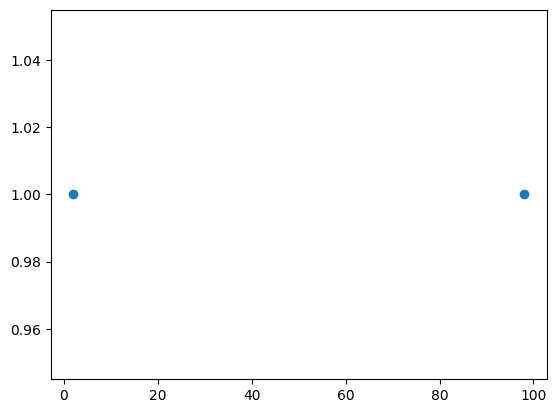

In [326]:
# defines atoms via covering
[eta, atoms] = position_points(K, P)
print(eta)

In [329]:
# define initial ambiguity set

weigths_init, counter_init = get_initial_weigths(np.array(samples_off),np.array(atoms))
radius_true_init = C*np.sqrt(np.log(1/beta_0))*(1/np.sqrt(N_off)) 
radius_init = radius_true_init + eta

print(radius_true_init)
print(eta)
print(counter_init)
print(weigths_init)

21.462796575676002
48.0
[15.  5.]
[0.75 0.25]


In [328]:
w,tmp,tmp1,tmp2 = gen_demand(1,0, mu, sig, P)
print(w)

[59.91418607]


In [330]:
weights_next, counter_next, radius_next = update_ambiguity(counter_init, N_off + (0+1), w, K, atoms, 0.7,C)
print(counter_next)
print(weights_next)

[15.  6.]
[0.71428571 0.28571429]


In [313]:
# set optimization routine
[problem, x, s, gamma_0, gamma_1, gamma_2, gamma_3, lam, d_train, wk, eps] = prob_news(K,P)

In [315]:
# optimization routine
T_sim = 1000

weights = weigths_init
counter = counter_init
radius = radius_init
d_train.value = atoms

obj = np.empty((T_sim,1))

for t in range(T_sim):
    wk.value = weights
    eps.value = radius
    problem.solve(solver = cp.CLARABEL)
    obj[t] = problem.value

    # new realization
    w,tmp,tmp1,tmp2 = gen_demand(1,0, mu, sig, P)
    
    # update confidence
    beta_next = alpha*np.power(r, t+1)

    # update ambiguity set
    weights_next, counter_next, radius_next = update_ambiguity(counter, N_off + (t+1), w, K, atoms, beta_next,C)
    weights = weights_next
    radius = radius_next + eta




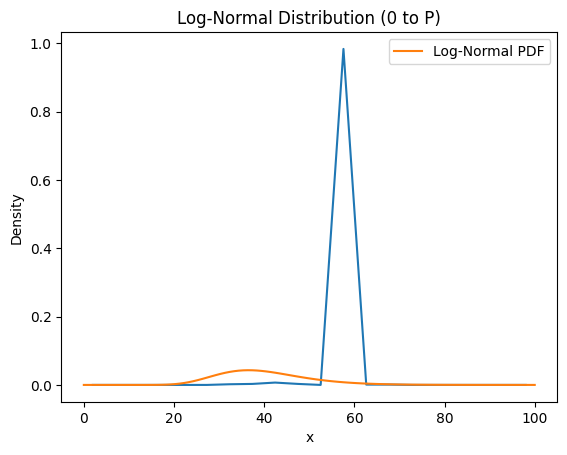

In [316]:
# plots distribution
plt.scatter(atoms, weights_next)
tmp,tmp1,s,scale = gen_demand(1,0, mu, sig, P) 
lognormal_dist = lognorm(s=s, scale=scale)
# Plot the probability density function (pdf)
x = np.linspace(0, P, 100)
plt.plot(x, lognormal_dist.pdf(x), label='Log-Normal PDF')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Log-Normal Distribution (0 to P)')
plt.legend()
plt.show()

0.6666666666666666
21.273183801726773
[523.40028406]


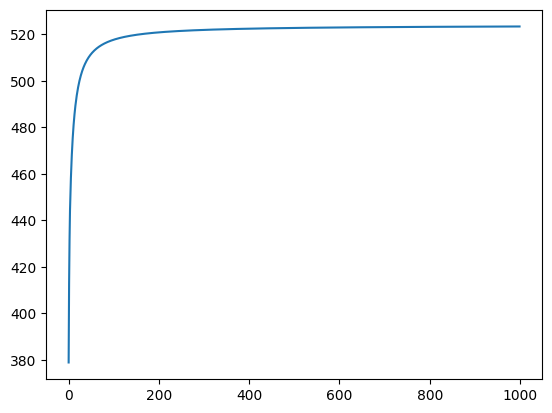

In [320]:
# plots
q = b/(h+b)
print(q)
ground_truth = np.percentile(true_dist, q)

plt.plot(obj)
print(ground_truth)
print(obj[-1])